In [1]:
import os
os.chdir("/Users/ulrikah/fag/thesis/rave")


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

from rave.sound import Sound
from rave.effect import Effect
from rave.analyser import Analyser
from rave.constants import KSMPS, SAMPLE_RATE
from rave.tools import sec_per_k

**Analysis**

Files to analyse (in `results/analysis`):

- rms_1000iters.wav
- rms_1000iters_debug.wav
- all_1000iters.wav
- all_1000iters_debug.wav

What I want to get out:
- RMS plot of bounced_files
- pitch plot of bounces_files
- spectral plot of bounced_files
- upsampled control rate params on top of each other

What I maybe want to get out:
- reward (but that requires the reward to be normalized)

**Retrieving the features**

In [95]:
feature_extractors = ["rms", "pitch", "spectral"]
analyser = Analyser(feature_extractors)

rms_bounce = "/Users/ulrikah/fag/thesis/results/analysis/rms_1000iters.wav"
all_bounce = "/Users/ulrikah/fag/thesis/results/analysis/all_1000iters.wav"
target     = "/Users/ulrikah/fag/thesis/rave/rave/input_audio/amen_5s.wav"

rms_sound = Sound(rms_bounce)
all_sound = Sound(all_bounce)
target_sound = Sound(target)
sounds = [rms_sound, all_sound, target_sound]
for sound in sounds:
    sound.prepare_to_render(analyser=analyser)
    sound.features = []

done = False

while not done:
    for sound in sounds:
        done = done or sound.render()
        channel_values = sound.player.get_channels(analyser.analysis_features)
        sound.features.append(channel_values)
print("Number of feature vectors", [len(s.features) for s in sounds])
print("(sr / ksmps) * duration", (SAMPLE_RATE / KSMPS) * sounds[0].duration)

Number of feature vectors [1724, 1724, 1724]
(sr / ksmps) * duration 1722.9999999999998


## Visualisation

In [96]:
def clean_csound_name(csound_var):
    """
    e.g. 
    kcentroid_l -> centroid
    aenv -> env
    """
    return csound_var[1:].split("_")[0]

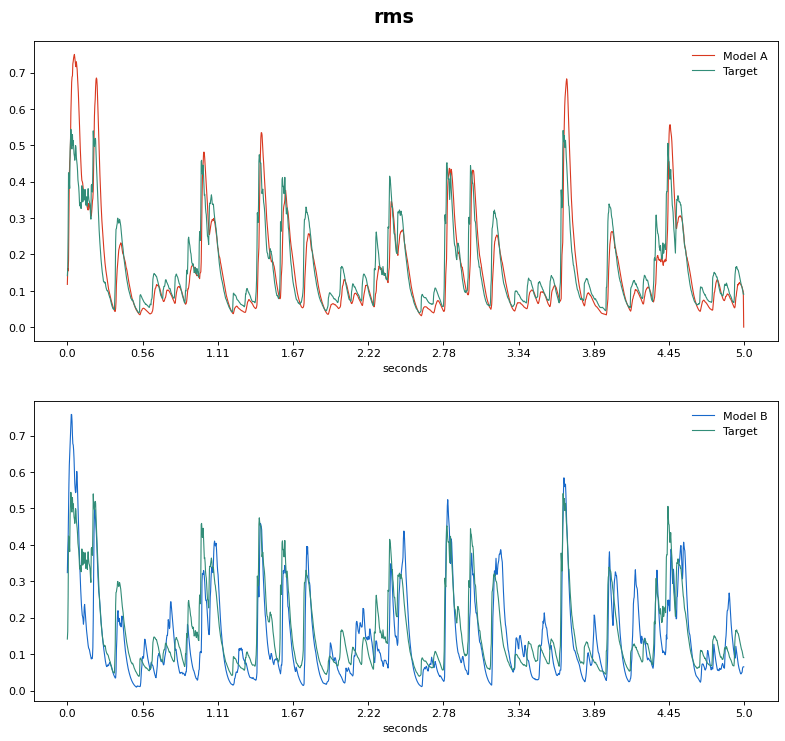

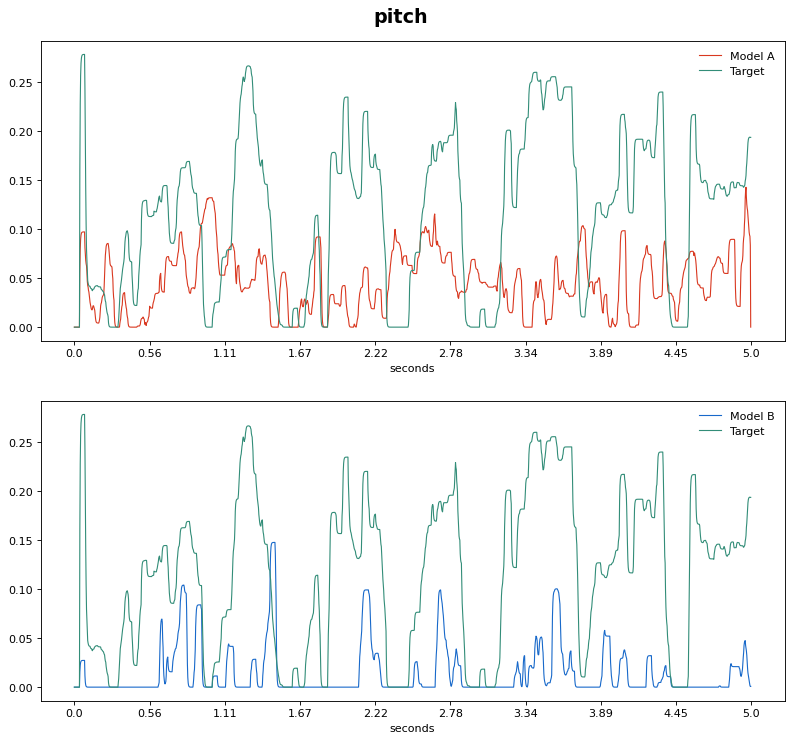

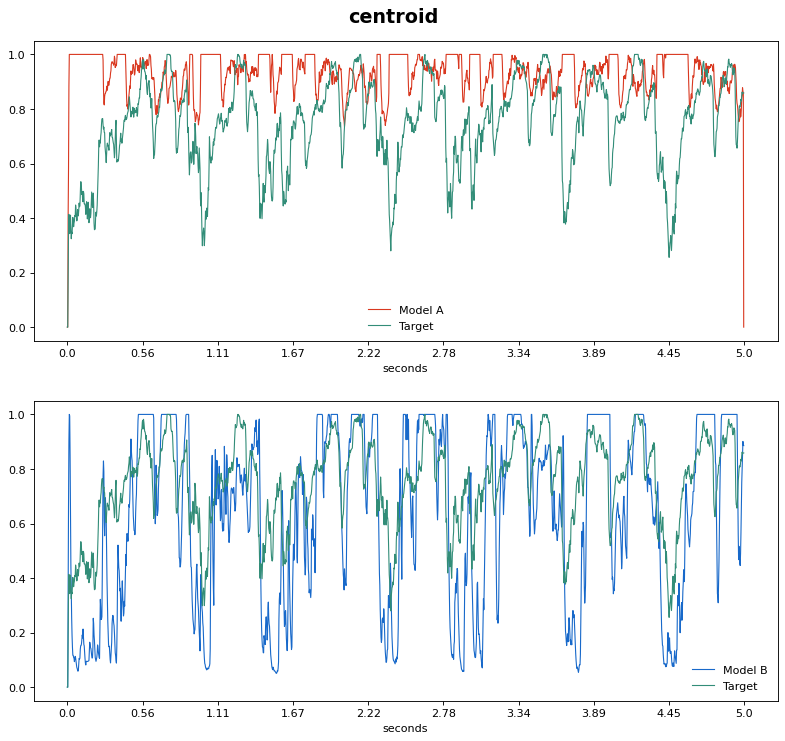

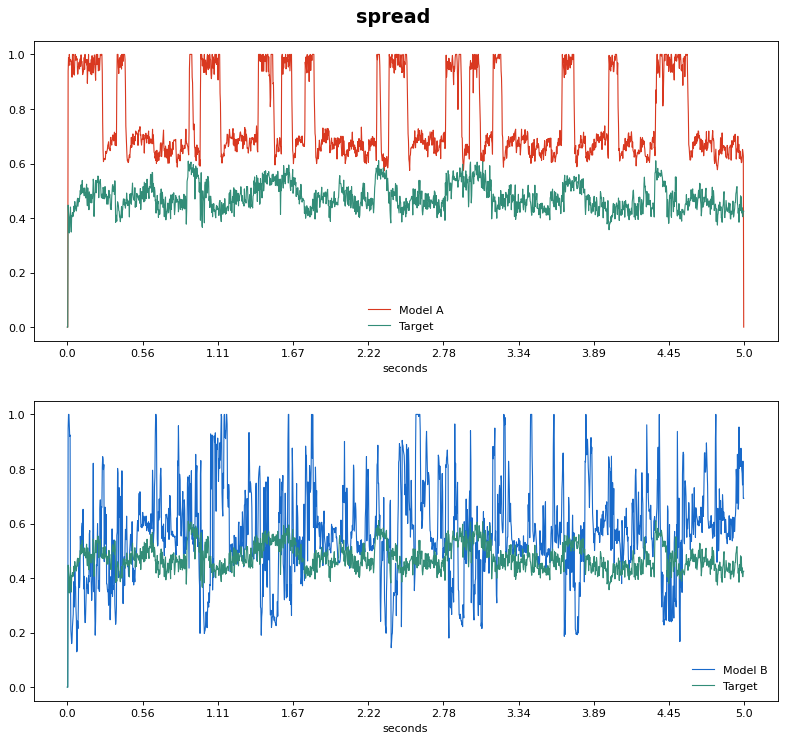

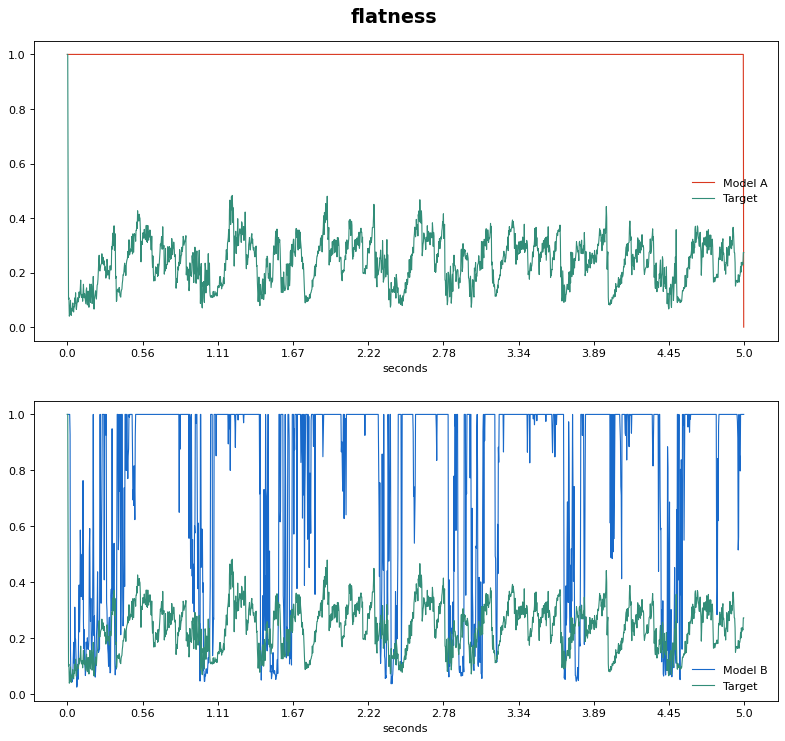

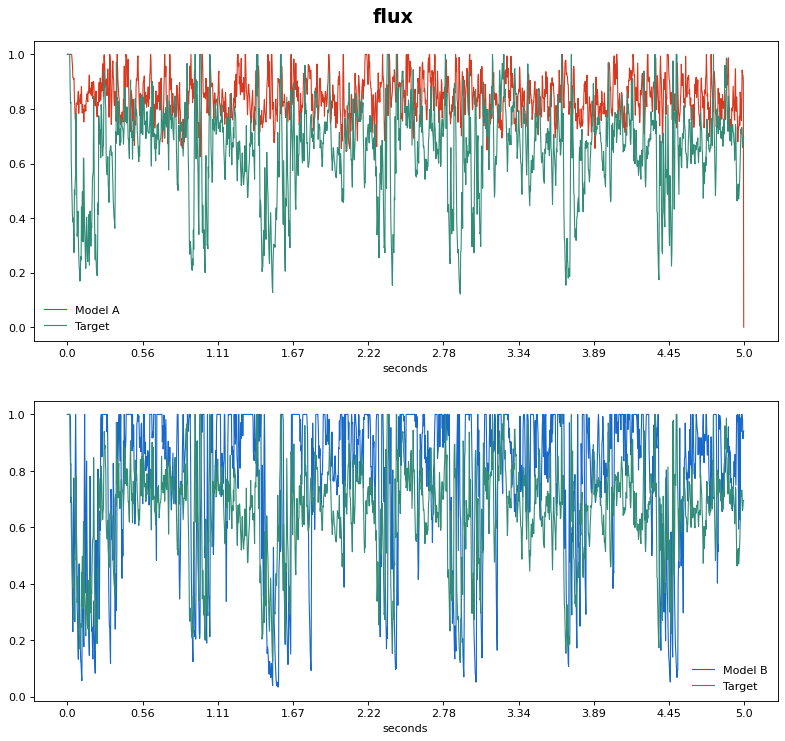

In [97]:
# numpyify
for sound in sounds:
    sound.features = np.array(sound.features)

sound_names = ["Model A", "Model B", "Target"]
sound_colors = [
    np.array([0.85181538, 0.22025192, 0.12469306]), 
    np.array([0.0950709 , 0.41044936, 0.79145089]),
    np.array([0.19786649, 0.55163671, 0.47055379])
]

n_frames = len(sounds[0].features)
n_xticks = 10
xtick_values = np.linspace(0, n_frames, num=n_xticks)
xtick_labels = [str(round(tick, 2)) for tick in xtick_values * sec_per_k(KSMPS, SAMPLE_RATE)]

rms_index = 0
all_index = 1
target_index = 2

feature_names = [clean_csound_name(f) for f in analyser.analysis_features]

for i, feature_name in enumerate(feature_names):
    # get values for current feature
    rms_feature = sounds[rms_index].features[:n_frames,i]
    all_feature = sounds[all_index].features[:n_frames,i]
    target_feature = sounds[target_index].features[:n_frames,i]

    fig = plt.figure(figsize=(12,10), dpi=80)
    fig.suptitle(feature_name, x=0.5, y=.98, size="xx-large", weight="bold", va="center", ha="center")
    fig.subplots_adjust(top=0.95)
    
    plt.subplot(2, 1, 1)
    plt.plot(rms_feature, c=sound_colors[0], label=f"{sound_names[0]}", linewidth=1, markersize=12)
    plt.plot(target_feature, c=sound_colors[2], label=f"{sound_names[2]}", linewidth=1, markersize=12)
    plt.xticks(xtick_values, xtick_labels)
    plt.xlabel("seconds")
    plt.legend(frameon=False)


    plt.subplot(2, 1, 2)
    plt.plot(all_feature, c=sound_colors[1], label=f"{sound_names[1]}", linewidth=1, markersize=12)
    plt.plot(target_feature, c=sound_colors[2], label=f"{sound_names[2]}", linewidth=1, markersize=12)
    plt.xticks(xtick_values, xtick_labels)
    plt.xlabel("seconds")
    plt.legend(frameon=False)

    plt.show()

## Visualize multi-track debug files

What I want to visualize:
- amen break (target)
- control channels for both debug files on top of each other

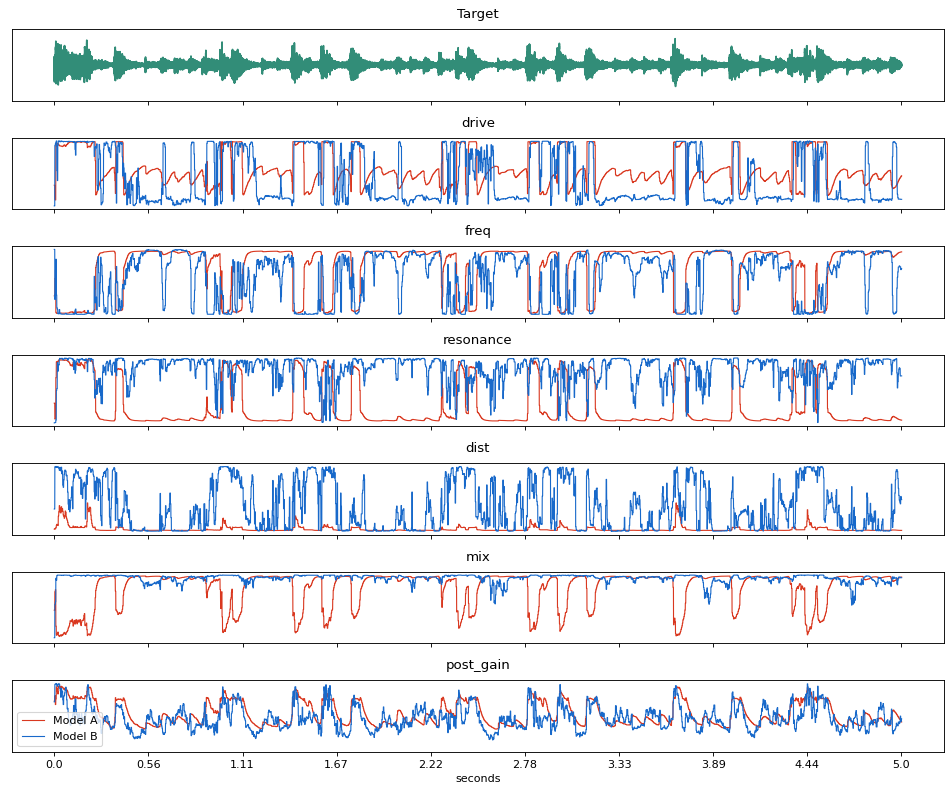

In [101]:
rms_debug = "/Users/ulrikah/fag/thesis/results/analysis/rms_1000iters_debug.wav"
all_debug = "/Users/ulrikah/fag/thesis/results/analysis/all_1000iters_debug.wav"

effect = Effect("dist_lpf")
channel_names = list(map(lambda param: param.name, effect.parameters))

target_y, _ = librosa.load(target, sr=SAMPLE_RATE, mono=True)
rms_y, _ = librosa.load(rms_debug, sr=SAMPLE_RATE, mono=False)
all_y, _ = librosa.load(all_debug, sr=SAMPLE_RATE, mono=False)

### Plotting ###
n_samples = target_y.size
n_xticks = 10
xtick_values = np.linspace(0, n_samples, num=n_xticks)
xtick_labels = [str(round(tick, 2)) for tick in xtick_values / SAMPLE_RATE]

fig, axs = plt.subplots(nrows=7, ncols=1, sharex=True, sharey=True, figsize=(12,10), dpi=80)
plt.yticks([])
plt.xticks(xtick_values, xtick_labels)
plt.xlabel("seconds")

axs[0].plot(target_y, c=sound_colors[2])
axs[0].set_title(label="Target", loc="center", pad="10", weight="bold")

# the first two channels in the debug waveform are the dry and wet, i.e. [dry, wet, ...parameters] so we offset by 2
assert y.shape[0] == len(channel_names) + 2
for i in range(2, 8): # omit the dry and wet channels
    axs[i-1].plot(rms_y[i], linewidth=1, markersize=12, c=sound_colors[0])
    axs[i-1].plot(all_y[i], linewidth=1, markersize=12, c=sound_colors[1])
    axs[i-1].set_title(label=channel_names[i - 2], loc="center", pad="10")

fig.tight_layout()
plt.legend(["Model A", "Model B"])
plt.show()
# plt.savefig("rave/plots/test.png", transparent=True)